In [4]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [5]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [21]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_25.json")

merger_info = pd.read_json(r"../../../data/processed/merger_info_2023_03_25.json")

### Balance data and split to train and test set

In [22]:
label_name = "wc"

In [23]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1574
0    1313
1     261
Name: label, dtype: int64
Balancing...
Total decisions: 522
Labels distribution: 
 0    261
1    261
Name: 0, dtype: int64
Training set shape: (417,) (417,)
Test set shape: (105,) (105,)
Creating df_train 1: 208 0: 209
Creating df_test1 1: 53 0: 52
Creating df_test concatenated with df_excluded with len: 1052
Creating df_test 1: 53 0: 1104
Grouping df_train by case_num 1: 208 0: 209
Grouping df_test by case_num 1: 53 0: 1104
Grouping df_test1 by case_num 1: 53 0: 52
Grouping df_excluded by case_num with len: 1052


In [24]:
df_train_grouped = pd.merge(df_train_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test_grouped = pd.merge(df_test_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test1_grouped = pd.merge(df_test1_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_excluded_grouped = pd.merge(df_excluded_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])

In [25]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [13]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (3,3)], # limit to trigrams
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [22]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=5, scoring='f1')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
done in 5628.176s
Best cross-validation score:  0.7765947755745944
Best parameters set:
	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [23]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=5)

fitting the best model
Accuracy: 0.7360774818401937

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.56      0.68       206
           1       0.68      0.91      0.78       207

    accuracy                           0.74       413
   macro avg       0.77      0.74      0.73       413
weighted avg       0.77      0.74      0.73       413


CR: (0.7677591260325074, 0.7356596782514891, 0.7278048190585603, None)

Confusion matrix:
 [[116  90]
 [ 19 188]] 

_______________________


 Accuracy: 73.608 
 Precision: 0.676 
 Recall: 0.908 
 F1: 0.775 
 FPR: 0.437 
 ROC_AUC: 0.736


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [24]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_wc.xlsx', index=True)
df_features_cv.head()

,feature,importance
2283,indirect subsidiary,0.686710
4912,vehicle company,-0.682168
2074,healthcare company,0.648330
1298,decision belgië,-0.613657
4021,risk covered,-0.557041


In [25]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.5425623387790198

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69      1110
           1       0.08      0.91      0.15        53

    accuracy                           0.54      1163
   macro avg       0.54      0.72      0.42      1163
weighted avg       0.95      0.54      0.66      1163


CR: (0.5374874297545105, 0.7154428012918579, 0.4197782329154569, None)

Confusion matrix:
 [[583 527]
 [  5  48]] 

_______________________


 Accuracy: 54.256 
 Precision: 0.083 
 Recall: 0.906 
 F1: 0.153 
 FPR: 0.475 
 ROC_AUC: 0.715


In [26]:
y_predict_cv_test1 = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.7142857142857143

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.52      0.64        52
           1       0.66      0.91      0.76        53

    accuracy                           0.71       105
   macro avg       0.75      0.71      0.70       105
weighted avg       0.75      0.71      0.70       105


CR: (0.7506421232876712, 0.71244557329463, 0.7023809523809524, None)

Confusion matrix:
 [[27 25]
 [ 5 48]] 

_______________________


 Accuracy: 71.429 
 Precision: 0.658 
 Recall: 0.906 
 F1: 0.762 
 FPR: 0.481 
 ROC_AUC: 0.712


### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [26]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,2), binary = True, max_df = 0.05, norm = 'l1', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [27]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.7177033492822966

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.56      0.67       209
           1       0.67      0.87      0.76       209

    accuracy                           0.72       418
   macro avg       0.74      0.72      0.71       418
weighted avg       0.74      0.72      0.71       418


CR: (0.7402298850574712, 0.7177033492822966, 0.7109266943291839, None)

Confusion matrix:
 [[118  91]
 [ 27 182]] 

_______________________


 Accuracy: 71.770 
 Precision: 0.667 
 Recall: 0.871 
 F1: 0.755 
 FPR: 0.435 
 ROC_AUC: 0.718


In [30]:
evaluate(y_train, y_predict_train)

Accuracy: 0.7177033492822966

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.56      0.67       209
           1       0.67      0.87      0.76       209

    accuracy                           0.72       418
   macro avg       0.74      0.72      0.71       418
weighted avg       0.74      0.72      0.71       418


CR: (0.7402298850574712, 0.7177033492822966, 0.7109266943291839, None)

Confusion matrix:
 [[118  91]
 [ 27 182]] 

_______________________


 Accuracy: 71.770 
 Precision: 0.667 
 Recall: 0.871 
 F1: 0.755 
 FPR: 0.435 
 ROC_AUC: 0.718


In [28]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.6433506044905009

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.63      0.77      1104
           1       0.11      0.91      0.19        54

    accuracy                           0.64      1158
   macro avg       0.55      0.77      0.48      1158
weighted avg       0.95      0.64      0.74      1158


CR: (0.5500441694734312, 0.7689210950080516, 0.4814859788259401, None)

Confusion matrix:
 [[696 408]
 [  5  49]] 

_______________________


 Accuracy: 64.335 
 Precision: 0.107 
 Recall: 0.907 
 F1: 0.192 
 FPR: 0.370 
 ROC_AUC: 0.769


In [29]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.7830188679245284

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.65      0.75        52
           1       0.73      0.91      0.81        54

    accuracy                           0.78       106
   macro avg       0.80      0.78      0.78       106
weighted avg       0.80      0.78      0.78       106


CR: (0.8015690776884807, 0.7806267806267806, 0.778585051312324, None)

Confusion matrix:
 [[34 18]
 [ 5 49]] 

_______________________


 Accuracy: 78.302 
 Precision: 0.731 
 Recall: 0.907 
 F1: 0.810 
 FPR: 0.346 
 ROC_AUC: 0.781


### Confusion matrix and model performance

In [31]:
def eval_matrix(df, X, y_true, y_pred):
    results = pd.DataFrame(np.column_stack((X, y_true, y_pred)), columns=['text', 'target', 'y_predict'])
    results = pd.concat([df, results], axis=1)

    tn=results[(results.target == 0) & (results.y_predict == 0)]
    fp=results[(results.target == 0) & (results.y_predict == 1)]
    fn=results[(results.target == 1) & (results.y_predict == 0)]
    tp=results[(results.target == 1) & (results.y_predict == 1)]

    return (results, tn, fp, fn, tp)


In [32]:
results_train, tn, fp, fn, tp = eval_matrix(df_train_grouped, X_train, y_train, y_predict_train)

In [76]:
results1, tn, fp, fn, tp = eval_matrix(df_test1_grouped, X_test1, y_test1, y_predict_test1)

In [78]:
results2, tn, fp, fn, tp = eval_matrix(df_test_grouped, X_test, y_test, y_predict_test)

In [79]:
print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 696
FP: 408
FN: 5
TP: 49


In [80]:
tn['nace_code'].value_counts().head(6)

Manufacture of chemicals and chemical products                                   18
Manufacture of other parts and accessories for motor vehicles                    17
Telecommunications                                                               14
Financial service activities, except insurance and pension funding               11
Insurance, reinsurance and pension funding, except compulsory social security     9
Wholesale of computers, computer peripheral equipment and software                8
Name: nace_code, dtype: int64

In [81]:
fp['nace_code'].value_counts().head(6)

Telecommunications                                                                                                    23
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                          12
Manufacture of chemicals and chemical products                                                                        10
Manufacture of pharmaceutical preparations                                                                             7
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms     6
Manufacture of paints, varnishes and similar coatings, printing ink and mastics                                        5
Name: nace_code, dtype: int64

In [83]:
fp['nace_code'].str.contains("pharma").sum()

32

In [84]:
fn['nace_code'].value_counts().head(6)

Manufacture of chemicals and chemical products                                                                                                                                                       1
Electric power generation, transmission and distribution                                                                                                                                             1
Cargo handling; Land transport and transport via pipelines; Sea and coastal freight water transport; Service activities incidental to water transportation; Support activities for transportation    1
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                                                                                                         1
Other telecommunications activities; Wired telecommunications activities; Wireless telecommunications activities                                                                                     1
Name:

In [85]:
tp['nace_code'].value_counts().head(6)

Manufacture of basic pharmaceutical products and pharmaceutical preparations                   6
Manufacture of chemicals and chemical products                                                 3
Aquaculture                                                                                    2
Information service activities; Programming and broadcasting activities; Telecommunications    2
Wireless telecommunications activities                                                         2
Computer programming, consultancy and related activities                                       2
Name: nace_code, dtype: int64

### Feature importance

In [44]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
458,care product,0.715537,0.715537
4248,share asset,0.613459,0.613459
2061,hold minority,0.587249,0.587249
4714,term new,0.584416,0.584416
2004,group eur,-0.461435,0.461435
4842,ultimate parent,-0.456595,0.456595
1306,decision belgië,-0.445218,0.445218
1519,economic entity,-0.422327,0.422327
2301,investment banking,-0.419932,0.419932
323,banking financial,-0.390281,0.390281


In [45]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [46]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

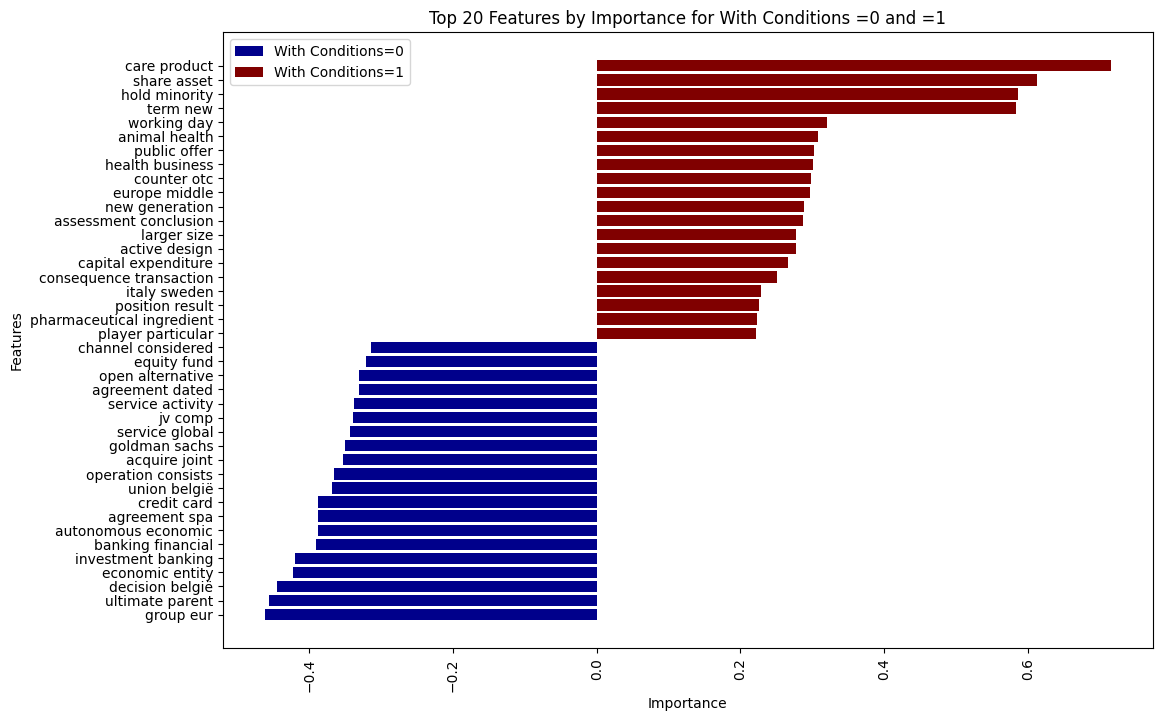

In [47]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='With Conditions=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [35]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_wc.xlsx', index=True)